In [1]:
import pickle
import os
import numpy as np
import rioxarray
import cv2
import geopandas as gpd
import pandas as pd
from pyproj import CRS
from shapely.geometry import Polygon
from shapely.ops import cascaded_union, unary_union
from tqdm import tqdm
import time
from random import shuffle

## Algorithm II: Instance Registration

Data structure: 
1. Each tile is noted with two spatial indices, i and j, which can be used to find its adjacent tiles.
2. Rocks are grouped by tiles and rocks' locations in a tile. Also, each rock is linked with its location and tile indices. Thus the indexing order is as follows: tile indices -> location -> rock index -> rock -> location & tile indices

Pseudo code:
```
for instance in instance:
    location, tile_indices = get_location_in_tile(instance)
    if location is not in tile_overlap:
        register(instance)
    else:
        adjacent_tiles = compute_adjacent_tiles(tile_indices)
        for adjacent_tile in adjacent_tiles:
            for adjacent_instance in adjacent_tile:
                if overlap_bbox(instance, adjacent_instance) > bbox_threshold:
                    if overlap_polygon(instance, adjacent_instance) > polygon_threshold:
                        merge(instance, adjacent_tile)
                        next instance # return
        register(instance)
```

In [2]:
class Instance_Registration(object):
    def __init__(self, instance_dir, 
                 save_shapefile,
                 tile_overlap_ratio=0.1, 
                 detection_threshold=0.75, 
                 segmentation_threshold=0.5, 
                 mask_overlap_threshold=0.1, 
                 disable_merge=False):
        
        assert os.path.exists(instance_dir)
        self.tile_files = [os.path.join(instance_dir, f) for f in os.listdir(instance_dir) if f.endswith('.pickle')]
        self.tiles = {}
        self.instances = []  # 
        tile_data = self._get_instance(self.tile_files[0])
        _, _, self.h, self.w = tile_data['masks'].shape
        tif_name = tile_data['image_name']
        tif = rioxarray.open_rasterio(tif_name)
        epsg = tif.rio.crs.to_epsg()
        self.crs = CRS(epsg)
        _, self.tiff_h, self.tiff_w = tif.shape
        self.tif_h_size, self.tif_v_size = tif.rio.resolution()
        self.mask_h_size = self.tif_h_size * self.tiff_h / self.h
        self.mask_v_size = self.tif_v_size * self.tiff_w / self.w
        self.overlap = self.h * tile_overlap_ratio
        self.mask_overlap = mask_overlap_threshold
        dir_path = os.path.dirname(os.path.realpath(tif_name))
        tif_name = os.path.join(dir_path, '0_0.tif')
        assert os.path.isfile(tif_name)
        tif = rioxarray.open_rasterio(tif_name)
        self.h_start, self.v_start, _, _= tif.rio.bounds()
        self.save_shapefile = save_shapefile
        self.detection_threshold = detection_threshold
        self.segmentation_threshold = segmentation_threshold
        self.disable_merge = disable_merge
        
        
    def start_registration(self):
        updated_tile_files = []
        timestamps = []
        self.instances = []
        self.tiles = {}
        print("Instance registration: ")
        start_time = time.time()
        for tile_file in tqdm(self.tile_files):
            tile_data = self._get_instance(tile_file)
            masks = tile_data['masks']
            instance_N = masks.shape[0]
            if instance_N == 0:
                continue
            updated_tile_files.append(tile_file)
            masks = np.squeeze(masks, axis=1)
            tif_name = tile_data['image_name']
            tile_indices = tuple([int(i) for i in tif_name.split('/')[-1].split('.')[0].split('_')])
            # post processing: detection confidence filter
            detect_scores = tile_data['scores']
            # prune data by detection_threshold
            masks = masks[detect_scores>self.detection_threshold]
            detect_scores = detect_scores[detect_scores>self.detection_threshold]
            for idx, mask in enumerate(masks):
                # post processing: segmentation confidence filter
                mask = mask > self.segmentation_threshold
                # post processing: contour analysis
                contours, _ = cv2.findContours(mask.astype(np.uint8).copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
                if len(contours) > 1:
                    areas = [cv2.contourArea(cnt) for cnt in contours]
                    i = np.argmax(areas)
                    contour = contours[i]
                    mask = np.zeros_like(mask).astype(np.uint8)
                    cv2.fillPoly(mask, pts =[contour], color=(255))
                    local_mask = mask > 0
                else:
                    contour = contours[0]
                    local_mask = mask
                # get location using pixel coords: top, bottom, left, right, middle
                contour = np.squeeze(contour, axis=1)
                locations = self._get_locations(contour)
                # convert masks to global mask
                global_mask = self._convert_global_mask(local_mask, tile_indices)
                # get global bbox
                global_bbox = self._get_global_bbox(global_mask)
                # instance registration
                instance = {'locations': locations, 
                            'tile_indices': tile_indices,
                            'score': detect_scores[idx], 
                            'global_bbox': global_bbox, 
                            'global_mask': global_mask}
                if self.disable_merge:
                    self.instances.append(instance)
                else:
                    self._instance_registration(instance)
            timestamps.append(time.time() - start_time)
                
        print("Instance #: ", len(self.instances))
        return updated_tile_files, timestamps
    
    
    def update_tile_files(self, updated_tile_files):
        self.tile_files = updated_tile_files
    
                
    def save(self):
        print('save shapefile: ')
        dataframesList = []
        for instance in tqdm(self.instances):
            geodataframe = gpd.GeoDataFrame(pd.DataFrame({'score': [instance['score']]}), 
                                           crs=self.crs, 
                                           geometry=[self._convert_mask_to_poly(instance)]) 
            dataframesList.append(geodataframe)
        rdf = gpd.GeoDataFrame(pd.concat(dataframesList, ignore_index=True))
        rdf.to_file(self.save_shapefile)
                
    def _instance_registration(self, instance):
        if 'middle' in instance['locations']:
            self._add_instance(instance)
            return None
        
        (x, y) = instance['tile_indices']
        merged = False
        for location in instance['locations']:
            if location == 'left':
                adjacent_indices = (x-1, y)
                adjacent_location = 'right'
                merged = merged | self._merge_instance(instance, location, adjacent_indices, adjacent_location)
            elif location == 'right':
                adjacent_indices = (x+1, y)
                adjacent_location = 'left'
                merged = merged | self._merge_instance(instance, location, adjacent_indices, adjacent_location)
            elif location == 'top':
                adjacent_indices = (x, y+1)
                adjacent_location = 'bottom'
                merged = merged | self._merge_instance(instance, location, adjacent_indices, adjacent_location)
            elif location == 'bottom':
                adjacent_indices = (x, y-1)
                adjacent_location = 'top'
                merged = merged | self._merge_instance(instance, location, adjacent_indices, adjacent_location)
        
        if not merged:
            self._add_instance(instance)
                
    def _add_instance(self, instance):
        self.instances.append(instance)
        instance_id = len(self.instances) - 1
        # update tile table
        if not self.tiles.get(instance['tile_indices'], False):
            # initialize tile
            empty_locations = {'left':[], 'right':[], 'top':[], 'bottom':[], 'middle':[]}
            self.tiles[instance['tile_indices']] = empty_locations
        # update tile
        for location in instance['locations']:
            self.tiles[instance['tile_indices']][location].append(instance_id)
                        
    def _merge_instance(self, instance, location, adjacent_indices, adjacent_location):
        if not self.tiles.get(adjacent_indices, False): 
            return False
        else:
            for adjacent_id in self.tiles[adjacent_indices][adjacent_location]:
                adjacent_instance = self.instances[adjacent_id]
                if self._bbox_intersection(instance['global_bbox'], adjacent_instance['global_bbox']):
                    overlap = self._mask_intersection_hash_method(instance['global_mask'], adjacent_instance['global_mask'])
                    #print(overlap)
                    #print(self._mask_intersection_brute_force_method(instance['global_mask'], adjacent_instance['global_mask']))
                    if overlap > self.mask_overlap:        
                        merged_mask = np.concatenate((instance['global_mask'], adjacent_instance['global_mask']))
                        merged_mask = np.unique(merged_mask, axis=0)
                        merged_mask = tuple(map(tuple, merged_mask))

                        self.instances[adjacent_id]['global_mask'] = merged_mask
                        self.instances[adjacent_id]['global_bbox'] = self._get_global_bbox(merged_mask)
                        self.instances[adjacent_id]['score'] = np.max((self.instances[adjacent_id]['score'], instance['score']))
                        
                        # tile is also expanded as instance merge
                        if not self.tiles.get(instance['tile_indices'], False):
                            empty_locations = {'left':[], 'right':[], 'top':[], 'bottom':[], 'middle':[]}
                            self.tiles[instance['tile_indices']] = empty_locations
                        for location in instance['locations']:
                            self.tiles[instance['tile_indices']][location].append(adjacent_id)
                            
                        return True
        return False
    

    
    
    def _mask_intersection_hash_method(self, mask1, mask2):
        mask_hash1 = [hash(mask_indices) for mask_indices in mask1]
        mask_hash2 = [hash(mask_indices) for mask_indices in mask2]
        return -np.count_nonzero(np.in1d(mask_hash1, mask_hash2, assume_unique=True)) * self.mask_h_size * self.mask_v_size
    
    def _mask_intersection_brute_force_method(self, mask1, mask2):
        overlap = len([px for px in mask1 if px in mask2])
        return -overlap * self.mask_h_size * self.mask_v_size
    
        
    def _convert_global_mask(self, mask, tile_indices):
        x = tile_indices[0] * (self.w - self.overlap)
        y = tile_indices[1] * (self.h - self.overlap) + self.h
        return tuple([(x+i, y-j) for j,i in np.asarray(np.nonzero(mask)).transpose()])
    
    def _get_global_bbox(self, mask):
        xmin, ymin = np.asarray(mask).min(axis=0)
        xmax, ymax = np.asarray(mask).max(axis=0)
        return [xmin, ymin, xmax, ymax]
    
    def _bbox_intersection(self, bbox1, bbox2):
        (xmin_a, ymin_a, xmax_a, ymax_a) = bbox1
        (xmin_b, ymin_b, xmax_b, ymax_b) = bbox2
        if xmin_a < xmax_b <= xmax_a and (ymin_a < ymax_b <= ymax_a or ymin_a <= ymin_b < ymax_a):
            return True
        elif xmin_a <= xmin_b < xmax_a and (ymin_a < ymax_b <= ymax_a or ymin_a <= ymin_b < ymax_a):
            return True
        elif xmin_b < xmax_a <= xmax_b and (ymin_b < ymax_a <= ymax_b or ymin_b <= ymin_a < ymax_b):
            return True
        elif xmin_b <= xmin_a < xmax_b and (ymin_b < ymax_a <= ymax_b or ymin_b <= ymin_a < ymax_b):
            return True
        else:
            return False
        
    def _get_instance(self, tile_file):
        with open(tile_file, 'rb') as handle:
            tile_data = pickle.load(handle)
        return tile_data
    
    def _get_locations(self, contour):
        x1, y1 = np.min(contour, axis=0)
        x2, y2 = np.max(contour, axis=0)
        locations = []
        if x1 < self.overlap:
            locations.append('left')
        if x2 > self.h - self.overlap:
            locations.append('right')
        if y1 < self.overlap:
            locations.append('top')
        if y2 > self.w - self.overlap:
            locations.append('bottom')
        if len(locations) == 0:
            locations.append('middle')
        return locations
        
        
    def _convert_mask_to_poly(self, instance):
        mask = np.asarray(instance['global_mask'])
        bbox = instance['global_bbox']
        bottom_left = np.asarray(mask).min(axis=0)
        local_mask = mask - bottom_left
        #print(local_mask.min(axis=0))
        #print(local_mask.max(axis=0))
        mask_shape = (int(bbox[2] - bbox[0]) + 1, int(bbox[3] - bbox[1]) + 1)  
        local_mask = self._create_bool_mask(local_mask, mask_shape)
        contours, _ = cv2.findContours(local_mask.astype(np.uint8).copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        assert len(contours) == 1
        contour = np.asarray(contours[0]) + bottom_left
        contour = contour.reshape(-1, 2).tolist()
        coords = [(self.h_start + pixel[0]*self.mask_h_size, 
                   self.v_start - pixel[1]*self.mask_v_size) 
                  for pixel in contour]
        coords = np.asarray(coords)
        poly = Polygon(zip(coords[:, 0].tolist(), coords[:, 1].tolist()))
        return poly

        
    def _create_bool_mask(self, mask, size):
        """
        :param mask: mask by index
        :param size: size of image
        :return: bool mask
        """
        mask_ = np.zeros(size)
        mask = mask.tolist()
        for x, y in mask:
            #if (x < size[0]) & (y < size[1]):
            mask_[int(x), int(y)] = 1
        return mask_.transpose()  # numpy ndarray dimension follows matrix convetion, which is different from euclidean coordinate convetion that cv2 contour analysis uses

In [3]:
ir = Instance_Registration('data/rocklas/prediction_2d', 
                           'data/rocklas/prediction_shapefiles/merged_inference_rock.shp', 
                           disable_merge=False)

In [4]:
updated_tile_files, timestamps = ir.start_registration()
ir.save()

Instance registration: 


100%|█████████████████████████████████████████| 441/441 [01:41<00:00,  4.35it/s]


Instance #:  516
save shapefile: 


100%|█████████████████████████████████████████| 516/516 [00:16<00:00, 30.93it/s]


## Examine algorithm time complexity

In [ ]:
# random tile sequence
time_table = []
for i in range(5):
    shuffle(updated_tile_files)
    ir.update_tile_files(updated_tile_files)
    _, timestamps = ir.start_registration()
    time_table.append(timestamps)

Instance registration: 


 16%|██████▉                                   | 43/261 [00:13<01:17,  2.80it/s]

In [6]:
import matplotlib.pyplot as plt

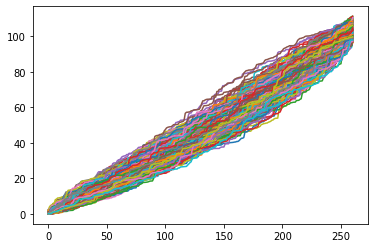

In [7]:
times = np.asarray(time_table)
#np.save('data/rocklas/time_complexity.npy', times)
_, n = times.shape
for t in times:
    plt.plot(range(n), t)
plt.show()

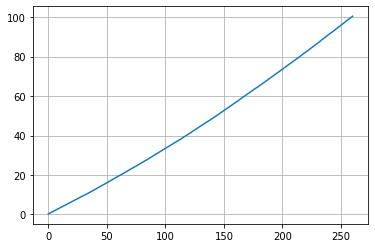

In [8]:
mean = times.mean(axis=0)
std = times.std(axis=0)

#plt.errorbar(range(n), mean, std, linestyle='None', marker='^')
plt.plot(range(n), mean)
plt.grid()
plt.show()

In [14]:
# ordered tile sequence
updated_tile_files.sort()
ir.update_tile_files(updated_tile_files)
_, timestamps = ir.start_registration()

Instance registration: 


100%|█████████████████████████████████████████| 261/261 [01:47<00:00,  2.42it/s]

Instance #:  516


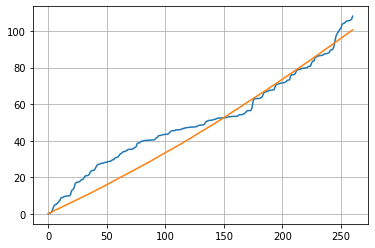

In [99]:
n = len(timestamps)
plt.plot(range(n), timestamps)
plt.plot(range(n), mean)
plt.grid()
plt.show()